#Decision Tree Exercise - Fake News Classifier
In this exercise, you will use decision tree to determine whether a headline is real or fake news. 

We have collected 1298 “fake news” headlines (which mostly include headlines of articles classified as biased etc.) and 1968 “real” news headlines. Before doing the exercise, please make sure you have uploaded `clean_real.txt`, and `clean_fake.txt` to the `/Colab Notebooks` folder in **your own** Google Drive, This exercise will read the data directly from Google Drive. Each headline appears as a single line in the data file.

In [2]:
import numpy as np
import pandas as pd
import random
from sklearn import tree
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from tqdm import tqdm
import string
import nltk
from nltk.corpus import stopwords
import nltk.stem as stemmer
from nltk.stem.porter import *
from sklearn.model_selection import GridSearchCV

# mount your Google Drive, so that you can read data from it.
# Note: it needs your authorization.
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# stemming tool from nltk
stemmer = PorterStemmer()
# a mapping dictionary that help remove punctuations
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def get_tokens(text):
    # turn document into lowercase
    lowers = text.lower()
    # remove punctuation
    no_punctuation = lowers.translate(remove_punctuation_map)
    # tokenize document
    tokens = nltk.word_tokenize(no_punctuation)
    # stop words
    filtered = [w for w in tokens if not w in stopwords.words("english")]
    # stemming process
    stemmed = []
    for item in filtered:
        stemmed.append(stemmer.stem(item))

    return stemmed

def get_dict(fpath):
    dictionary = {}


    with open(fpath, "r") as f:
        for i, word in enumerate(f):
            dictionary[word.strip()] = i

    return dictionary

def get_doc_tf(word_set, dictionary):
    n_words = len(dictionary)
    tf_vec = np.zeros(n_words)

    max_cnt = 0
    for word in word_set:
        idx = dictionary[word]
        tf_vec[idx] += 1.0

        if tf_vec[idx] > max_cnt:
            max_cnt = tf_vec[idx]

    return tf_vec / max_cnt

def filter_top_k(counter_sorted, limit):
    top_k = {}

    for i, k in enumerate(counter_sorted.keys()):
        if i == limit:
            break
        top_k[k] = counter_sorted[k]

    return top_k

def get_tf_idf(tf_dict, df_vec, n_doc, n_words):

    tf_idf_mtx = np.zeros((n_doc, n_words))
    idf = np.log(n_doc / df_vec)

    for doc_idx, tf_vec in tf_dict.items():
        tf_idf = tf_dict[doc_idx]*idf

        tf_idf_mtx[doc_idx, :] = tf_idf

    return tf_idf_mtx

def tfidf_main(fpath, dictionary):


    n_words = len(dictionary)
    tf = {}
    doc_freq = np.zeros(n_words)

    with open(fpath, 'r') as f:

        lines = f.readlines()
        n_doc = len(lines) - 1

        for i, line in tqdm(enumerate(lines), total=n_doc+1):
            if i == 0:
                continue

            doc_idx = i - 1

            id, txt, cat = line.split(",")
            cat = cat.strip()
            tokens = get_tokens(txt)

            filtered = []
            filtered_unique = set()
            for word in tokens:
                if word in dictionary:
                    filtered.append(word)
                    filtered_unique.add(word)

            # get term frequency
            tf_vec = get_doc_tf(filtered, dictionary)
            tf[doc_idx] = tf_vec

            # get doc frequency:
            for word in filtered_unique:
                idx = dictionary[word]
                doc_freq[idx] += 1


    tfidf_mtx = get_tf_idf(tf, doc_freq, n_doc, n_words)


    return tfidf_mtx

###Part 1: Data Loading

Read the data of each file into a list. The element of the list is a string (a news headline). We have completed this part for you.


In [4]:
def load_data(file):
    with open(file, 'r') as f:
        lines = f.readlines()

    return lines

# real_file = "tech.txt"
# fake_file = "not_tech.txt"

dictionary = get_dict("dictionary.txt")
tfidf = tfidf_main("news-train.csv", dictionary)

# real_data = load_data(real_file)
# fake_data = load_data(fake_file)

# print(real_data[:5])
# print(fake_data[:5])

100%|██████████| 1491/1491 [01:19<00:00, 18.77it/s]


###Part 2: Divide Data into Train/Val and Test
You will randomly divide the data into two parts: Train/Val (80%) and Test (20%). 
* Shuffle the data to a random order.
* Divide the data into Train/Val and Test.
* Combine the "fake" and "real" data.

We use numpy arrays to store the labels (`1` represents "real" and `0` represents "fake"). They also need to be divided and combined.

In [5]:
random.seed(0)
# random.shuffle(real_data)
# random.shuffle(fake_data)

# real_y = np.ones((len(real_data),))
# fake_y = np.zeros((len(fake_data),))

fileReader = pd.read_csv('news-train.csv')
categories = fileReader['Category']
le = preprocessing.LabelEncoder()
all_y = le.fit_transform(categories)
articles = fileReader['Text']

random.shuffle(articles)
##########################
# num_real_train_val = int(len(real_data) * 0.8)
# num_fake_train_val = int(len(fake_data) * 0.8)
num_train_val = int(len(all_y) * 0.8)

from sklearn.model_selection import train_test_split
train_val_X, test_X, train_val_y, test_y = train_test_split(tfidf, all_y, test_size=0.2, random_state=0)
print(train_val_y)

train_val_data = tfidf[:num_train_val]
test_data = tfidf[num_train_val:]

# train_val_data = real_data[:num_real_train_val] + fake_data[:num_fake_train_val]
# test_data = real_data[num_real_train_val:] + fake_data[num_fake_train_val:]

# train_val_y = train_val_data
# test_y = test_data
##########################

print(len(train_val_data), len(train_val_y))
print(len(test_data), len(test_y))

/usr/local/Cellar/python@3.9/3.9.10/Frameworks/Python.framework/Versions/3.9/lib/python3.9/random.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i], x[j] = x[j], x[i]


[4 4 1 ... 1 0 4]
1192 1192
298 298


###Part 3: Text Feature Extraction
You will build feature vectors for all headlines with `sklearn` package. Specifically, in this exercise, we use `sklearn.feature_extraction.text.CountVectorizer` which converts the headline into a sparse vector. For more details, please refer to https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_extraction.text

In [6]:
##########################
vectorizer = CountVectorizer()
# train_val_X = vectorizer.fit_transform(train_val_data)
# test_X = vectorizer.transform(test_data)
# train_val_X = all_y[:num_train_val]
# test_X = all_y[num_train_val:]
##########################

print(train_val_X.shape)
print(test_X.shape)

(1192, 1000)
(298, 1000)


###Part 4: Decision Tree Parameter Tuning via Cross Validation
In this part, you will train a decision tree with the Train/Val data, then use the tree to classify the Test data. Here, we build the decision tree with `sklearn.tree.DecisionTreeClassifier`.

- You need to find the optimal parameters for the decision tree. In particular, the **depth of tree** is an important parameter. The K-Folds cross-validation will be conducted to find the best parameter by using `sklearn.model_selection.KFold`.
 We choose the number of folds as **K=5**.

- After get the best parameter, you will evaluate the classification performance of the decision tree model on the Test data.



In [7]:
def dtc_parameter_tune(train_val_X, train_val_y):
    depths = [10, 25, 50, 75, 100, 125, 150]
    gini_train_acc_all = []
    gini_val_acc_all = []
    entr_train_acc_all = []
    entr_val_acc_all = []

    kf = KFold(n_splits = 5)
    for depth in depths:
        gini_train_acc = []
        gini_val_acc = []
        entr_train_acc = []
        entr_val_acc = []
        for train_index, val_index in kf.split(train_val_X):
            ##########################
            train_X = train_val_X[train_index,:]
            val_X = train_val_X[val_index,:]

            train_y = train_val_y[train_index]
            val_y = train_val_y[val_index]
            
            gini_dtc = tree.DecisionTreeClassifier(criterion="gini", max_depth=depth)
            gini_dtc.fit(train_X, train_y)
            gini_train_acc.append(gini_dtc.score(train_X, train_y))
            gini_val_acc.append(gini_dtc.score(val_X, val_y))
            entr_dtc = tree.DecisionTreeClassifier(criterion="entropy", max_depth=depth)
            entr_dtc.fit(train_X, train_y)
            entr_train_acc.append(entr_dtc.score(train_X, train_y))
            entr_val_acc.append(entr_dtc.score(val_X, val_y))
            ##########################

        avg_gini_train_acc = sum(gini_train_acc) / len(gini_train_acc)
        avg_gini_val_acc = sum(gini_val_acc) / len(gini_val_acc)
        avg_entr_train_acc = sum(entr_train_acc) / len(entr_train_acc)
        avg_entr_val_acc = sum(entr_val_acc) / len(entr_val_acc)
        print("Depth: ", depth)
        print("Training accuracy: ", avg_gini_train_acc * 100, "%")
        print("Validation accuracy: ", avg_gini_val_acc * 100, "%")

        gini_train_acc_all.append(avg_gini_train_acc)
        gini_val_acc_all.append(avg_gini_val_acc)
        entr_train_acc_all.append(avg_entr_train_acc)
        entr_val_acc_all.append(avg_entr_val_acc)

    return depths, gini_train_acc_all, gini_val_acc_all, entr_train_acc_all, entr_val_acc_all

depths, gini_train_acc_all, gini_val_acc_all, entr_train_acc_all, entr_val_acc_all  = dtc_parameter_tune(train_val_X, train_val_y)

# plot training/validation curves
# plt.plot(depths, train_acc_all, marker='.', label="Training accuracy")
# plt.plot(depths, val_acc_all, marker='.', label="Validation accuracy")
# plt.xlabel('Depth of tree')
# plt.ylabel('Accuracy')
# plt.legend()


Depth:  10
Training accuracy:  86.74502453908104 %
Validation accuracy:  75.5873562814247 %
Depth:  25
Training accuracy:  99.85309548793285 %
Validation accuracy:  79.19341795295524 %
Depth:  50
Training accuracy:  100.0 %
Validation accuracy:  80.36848212088182 %
Depth:  75
Training accuracy:  100.0 %
Validation accuracy:  79.86568686051827 %
Depth:  100
Training accuracy:  100.0 %
Validation accuracy:  80.28585492774516 %
Depth:  125
Training accuracy:  100.0 %
Validation accuracy:  79.69761963362751 %
Depth:  150
Training accuracy:  100.0 %
Validation accuracy:  80.2000632889139 %


Text(0, 0.5, 'Error')

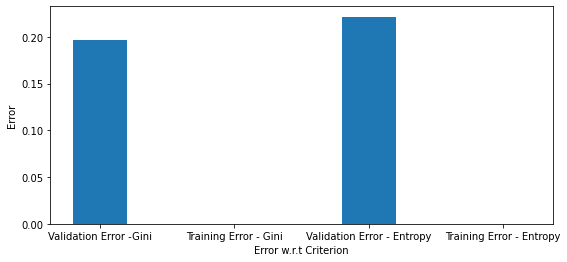

In [8]:
cv = {
    "Validation Error -Gini" : 1 - gini_val_acc_all[np.argmax(gini_val_acc_all)],
    "Training Error - Gini" : 1 - gini_train_acc_all[np.argmax(gini_val_acc_all)],
    "Validation Error - Entropy" : 1 - entr_val_acc_all[np.argmax(gini_val_acc_all)],
    "Training Error - Entropy" : 1 - entr_train_acc_all[np.argmax(entr_val_acc_all)]
}

fig = plt.figure(figsize = (9, 4))
def addlabels(x,y):
    for i in range(len(x)):
        plt. text(i, y[i], y[i], ha = 'center')

x = list(cv.values())
y = list(cv.keys())

plt.bar(y, x, width = 0.4)
plt.xlabel("Error w.r.t Criterion")
plt.ylabel("Error")

# idx = np.arange(2)
# print(idx)
# gini_err = [1 - gini_train_acc_all[np.argmax(gini_val_acc_all)], 1 - gini_val_acc_all[np.argmax(gini_val_acc_all)]]
# entr_err = [1 - entr_train_acc_all[np.argmax(entr_val_acc_all)], 1 - entr_val_acc_all[np.argmax(entr_val_acc_all)]]
# # df = pd.DataFrame(gini_err, columns=["gini"])
# # df.plot.bar()
# plt.bar(idx, gini_err, 0.4, label='Gini')
# plt.bar(idx + 0.4, entr_err, 0.4, label='Entropy')
# plt.ylabel('Error')
# plt.xticks(idx + 0.4 / 2, ('Train error', 'Val error'))
# plt.legend(loc='best')
# plt.show()

###Part 5: Evaluating the decision tree model on Test data

In [9]:
##########################
best_depth = depths[np.argmax(gini_val_acc_all)]
dtc = tree.DecisionTreeClassifier(max_depth=best_depth)
dtc.fit(train_val_X, train_val_y)
train_acc = dtc.score(train_val_X, train_val_y)
test_acc = dtc.score(test_X, test_y)
##########################
print("=========================================")
print("Best depth: ", best_depth)
print("Training accuracy: ", train_acc * 100, "%")
print("Test accuracy: ", test_acc * 100, "%")

Best depth:  50
Training accuracy:  100.0 %
Test accuracy:  83.55704697986577 %


    criterion  max_features  min_samples_leaf  mean_train_score  \
0        gini           200                 1          1.000000   
1        gini           200                 2          0.965436   
2        gini           200                 3          0.937416   
3        gini           200                 4          0.914094   
4        gini           200                 5          0.900503   
..        ...           ...               ...               ...   
155   entropy           800                16          0.833221   
156   entropy           800                17          0.826846   
157   entropy           800                18          0.815772   
158   entropy           800                19          0.810067   
159   entropy           800                20          0.808221   

     mean_test_score  
0           0.777181  
1           0.787919  
2           0.798658  
3           0.771141  
4           0.779195  
..               ...  
155         0.754362  
156        

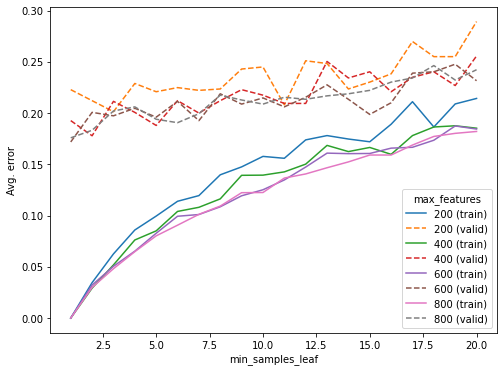

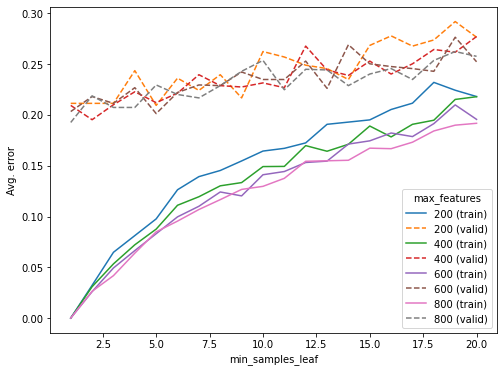

In [10]:

p_dtc = {
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': range(1, 21), 
    'max_features': range(200, 1000, 200)
}
CV_DTC = GridSearchCV(tree.DecisionTreeClassifier(), p_dtc, return_train_score=True)
CV_DTC.fit(tfidf, all_y)

res = pd.DataFrame(CV_DTC.cv_results_['params'])
res['mean_train_score'] = pd.DataFrame(CV_DTC.cv_results_)['mean_train_score']
res['mean_test_score'] = pd.DataFrame(CV_DTC.cv_results_)['mean_test_score']

print(res)
for i in p_dtc['criterion']:
    plt.figure(figsize=(8, 6))
    for x in p_dtc['max_features']:
        xy = res[(res['criterion'] == i) & (res['max_features'] == x)]
        plt.plot(xy['min_samples_leaf'], 1-xy['mean_train_score'], label=f'{x} (train)')
        plt.plot(xy['min_samples_leaf'], 1-xy['mean_test_score'], linestyle='--', label=f'{x} (valid)')
    plt.xlabel('min_samples_leaf')
    plt.ylabel('Avg. error')
    plt.legend(title='max_features')
    plt.savefig("2b.png")
    plt.show()



In [11]:
from sklearn.ensemble import RandomForestClassifier
p_rf = {'n_estimators': range(50, 1001, 50)}
CV_DTC = GridSearchCV(RandomForestClassifier(), p_rf, return_train_score=True)
CV_DTC.fit(tfidf, all_y)

for i in range(p_rf['n_estimators']):
    
    print(CV_DTC.cv_results_['mean_test_score'])
    print(CV_DTC.cv_results_['std_test_score'])

# # Graphing Average Accuracy
# plt.plot(p_rf['n_estimators'], CV_DTC.cv_results_['mean_test_score'], marker='.', label='val accuracy')
# plt.ylabel('avg accuracy')
# plt.xlabel('number of estimators')
# plt.legend()
# plt.savefig('3d1.png')
# plt.show()
# # Graphing Stadard Deviation Accuracy
# plt.plot(p_rf['n_estimators'], CV_DTC.cv_results_['std_test_score'], marker='.', label='val accuracy standard deviation')
# plt.ylabel('accuracy standard deviation')
# plt.xlabel('number of estimators')
# plt.legend()
# plt.savefig('3b2.png')
# plt.show()

50
[0.94563758 0.95033557 0.95302013 0.95704698 0.95704698 0.9590604
 0.96107383 0.95838926 0.95369128 0.9590604  0.9557047  0.96107383
 0.95838926 0.95973154 0.95771812 0.95704698 0.95838926 0.96174497
 0.95838926 0.9590604 ]
[0.01649424 0.01189265 0.0171108  0.01818284 0.01565356 0.0167651
 0.0171896  0.01509694 0.01550902 0.01565356 0.01090475 0.01211777
 0.01301391 0.01470396 0.01596695 0.01867172 0.01448794 0.01679194
 0.01448794 0.01607939]
100
[0.94563758 0.95033557 0.95302013 0.95704698 0.95704698 0.9590604
 0.96107383 0.95838926 0.95369128 0.9590604  0.9557047  0.96107383
 0.95838926 0.95973154 0.95771812 0.95704698 0.95838926 0.96174497
 0.95838926 0.9590604 ]
[0.01649424 0.01189265 0.0171108  0.01818284 0.01565356 0.0167651
 0.0171896  0.01509694 0.01550902 0.01565356 0.01090475 0.01211777
 0.01301391 0.01470396 0.01596695 0.01867172 0.01448794 0.01679194
 0.01448794 0.01607939]
150
[0.94563758 0.95033557 0.95302013 0.95704698 0.95704698 0.9590604
 0.96107383 0.95838926 0.95

/usr/local/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


    train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \
0              0.278183            0.003545            0.463401   
1              0.144048            0.002822            0.331574   
2              0.080748            0.002885            0.268764   
3              0.049655            0.001800            0.223669   
4              0.032534            0.001577            0.204385   
5              0.023008            0.001068            0.186058   
6              0.017400            0.000904            0.180564   
7              0.013752            0.000626            0.167432   
8              0.011481            0.000403            0.163868   
9              0.009754            0.000347            0.161864   
10             0.008746            0.000317            0.166063   
11             0.008076            0.000312            0.158370   
12             0.007423            0.000312            0.161010   
13             0.006830            0.000222            0.16272

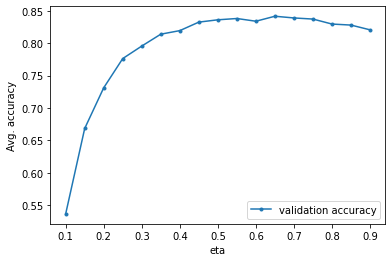

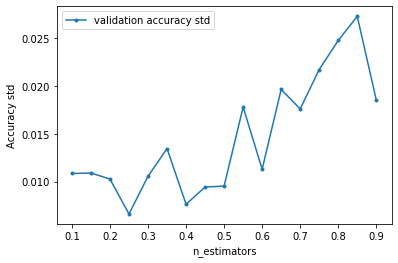

In [12]:
# import xgboost as xgb
# print(xgb.__version__)
# from xgboost import XGBClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# from xgboost import plot_tree
# from sklearn.metrics import accuracy_score

# lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

# for learning_rate in lr_list:
#     gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
#     gb_clf.fit(train_val_X, train_val_y)

# for i in train_val_X:
#      print(gb_clf.staged_predict(i))


import xgboost as xgb
xgb.set_config(verbosity=0)

xgb_matrix = xgb.DMatrix(np.array(tfidf), label=all_y)
y_list = []
lr = []
for i in range(10, 95, 5):
    params = { 'eta': i/100, 'num_class': 5 }
    xgb_cv = xgb.cv(params, xgb_matrix, num_boost_round=20 )
    y_loc = xgb_cv.iloc[-1].to_dict()
    y_loc['eta'] = i/100
    y_list.append(y_loc)
    lr.append(i/100)

jeffry = pd.DataFrame(y_list)
print(jeffry)
plt.plot(lr, 1-jeffry['test-mlogloss-mean'], marker='.', label='validation accuracy')
plt.xlabel('eta')
plt.ylabel('Avg. accuracy')
plt.legend()
plt.savefig('4_d1.png')
plt.show()

plt.plot(lr, jeffry['test-mlogloss-std'], marker='.', label='validation accuracy std')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy std')
plt.legend()
plt.savefig('4_d2.png')
plt.show()


# from sklearn.ensemble import GradientBoostingClassifier
# p_rf = {
#     'n_estimators': range(50, 1001, 50),
#     'max_depth': [10, 25, 50, 75, 100, 125, 150]

#     }
# CV_DTC = GridSearchCV(GradientBoostingClassifier(), p_rf, return_train_score=True)
# CV_DTC.fit(tfidf, all_y)

# plt.plot(p_rf['n_estimators'], CV_DTC.cv_results_['test_merror_score'], marker='.', label='val accuracy')
# plt.ylabel('avg accuracy')
# plt.xlabel('number of estimators')
# plt.legend()
# plt.show()

# clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=best_depth, random_state=0)
# clf.fit(tfidf, all_y)

# clf_score = clf.score()
# print("clf score:",clf_score)
# plt.show()

###Part 6: Visualizing Decision Tree
Finally, you will visualize the decision tree by using `sklearn.tree.export_graphviz`.

In [13]:
##########################
dot_data = tree.export_graphviz(dtc, filled=True, rounded=True, feature_names=vectorizer.get_feature_names(), class_names=["Fake", "Real"])
graph = graphviz.Source(dot_data)
##########################
graph

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


NotFittedError: Vocabulary not fitted or provided